World Cup Learning
------------------

Here I try to predict fifa world cup matches results, based on the knowledge of previous matches from the cups since the year 1950.

I'll use a MLP neural network classifier, my inputs will be the past matches (replacing each team name with a lot of stats from both), and my output will be a number indicating the result (0 = tie, 1 = wins team1, 2 = wins team2).

I'll be using pybrain for the classifier, pandas to hack my way through the data, and pygal for the graphs (far easier than matplotlib). And a lot of extra useful things implemented in the utils.py file, mostly to abstract the data processing I need before I feed the classifier.

In [1]:
from random import random

from IPython.display import SVG
import pygal

from pybrain.structure import SigmoidLayer
from pybrain.tools.shortcuts import buildNetwork
from pybrain.supervised.trainers import BackpropTrainer
from pybrain.datasets import ClassificationDataSet
from pybrain.utilities import percentError

from utils import get_matches, get_team_stats, extract_samples, normalize, split_samples, graph_teams_stat_bars, graph_matches_results_scatter


Configs
-------

In [2]:
# the features I will feed to the classifier as input data.
input_features = ['year',
                  'matches_won_percent',
                  'podium_score_yearly',
                  'matches_won_percent_2',
                  'podium_score_yearly_2',]

# the feature giving the result the classifier must learn to predict (I recommend allways using 'winner')
output_feature = 'winner'

# used to avoid including tied matches in the learning process. I found this greatly improves the classifier accuracy.
# I know there will be some ties, but I'm willing to fail on those and have better accuracy with all the rest.
# at this point, this code will break if you set it to False, because the network uses a sigmoid function with a 
# threeshold for output, so it is able to distinquish only 2 kinds of results.
exclude_ties = True

# used to duplicate matches data, reversing the teams (team1->team2, and viceversa). 
# This helps on visualizations, and also improves precission of the predictions avoiding a dependence on the
# order of the teams from the input.
duplicate_with_reversed = True

In [3]:
def show(graph):
    '''Small utility to display pygal graphs'''
    return SVG(graph.render())

Team stats
----------

First we need the teams stats. We can't feed the classifier inputs like ('Argentina', 'Brazil'), we need to give it numbers. And not any numbers, not just ids, but numbers that could be somewhat related to the result of the matches.

For example: the percentage of won matches of each team is something that could have an impact in the result, so that stat is a very good candidate.

We just calculate a lots of stats per team, and after we will decide which ones to use.

In [4]:
team_stats = get_team_stats()
team_stats

utils.py:77: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  winners = pd.DataFrame.from_csv(RAW_WINNERS_FILE)
utils.py:34: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  matches = pd.DataFrame.from_csv(RAW_MATCHES_FILE)


,matches_played,matches_won,years_played,podium_score,cups_won,matches_won_percent,podium_score_yearly,cups_won_yearly
team,,,,,,,,
Brazil,100.0,67.0,17.0,102,5.0,67.000000,6,0.294118
Canada,3.0,0.0,1.0,False,0.0,0.000000,0,0.000000
Serbia and Montenegro,3.0,0.0,1.0,False,0.0,0.000000,0,0.000000
Korea DPR,7.0,1.0,2.0,False,0.0,14.285714,0,0.000000
Scotland,23.0,4.0,8.0,False,0.0,17.391304,0,0.000000
Costa Rica,17.0,5.0,4.0,False,0.0,29.411765,0,0.000000
Ivory Coast,9.0,3.0,3.0,False,0.0,33.333333,0,0.000000
Wales,5.0,1.0,1.0,False,0.0,20.000000,0,0.000000
Argentina,75.0,40.0,14.0,48,2.0,53.333333,3.42857,0.142857


Lets visualize some of those stats, just because it helps paint a bigger picture on how good the teams are.

(you can hoover with your mouse on the '...' from the x axys to see the team name)

In [5]:
team_stats.sort_values('matches_won_percent')

,matches_played,matches_won,years_played,podium_score,cups_won,matches_won_percent,podium_score_yearly,cups_won_yearly
team,,,,,,,,
Togo,3.0,0.0,1.0,False,0.0,0.000000,0,0.000000
Angola,3.0,0.0,1.0,False,0.0,0.000000,0,0.000000
Honduras,9.0,0.0,3.0,False,0.0,0.000000,0,0.000000
Kuwait,3.0,0.0,1.0,False,0.0,0.000000,0,0.000000
Israel,3.0,0.0,1.0,False,0.0,0.000000,0,0.000000
Haiti,3.0,0.0,1.0,False,0.0,0.000000,0,0.000000
Bolivia,4.0,0.0,2.0,False,0.0,0.000000,0,0.000000
New Zealand,6.0,0.0,2.0,False,0.0,0.000000,0,0.000000
United Arab Emirates,3.0,0.0,1.0,False,0.0,0.000000,0,0.000000


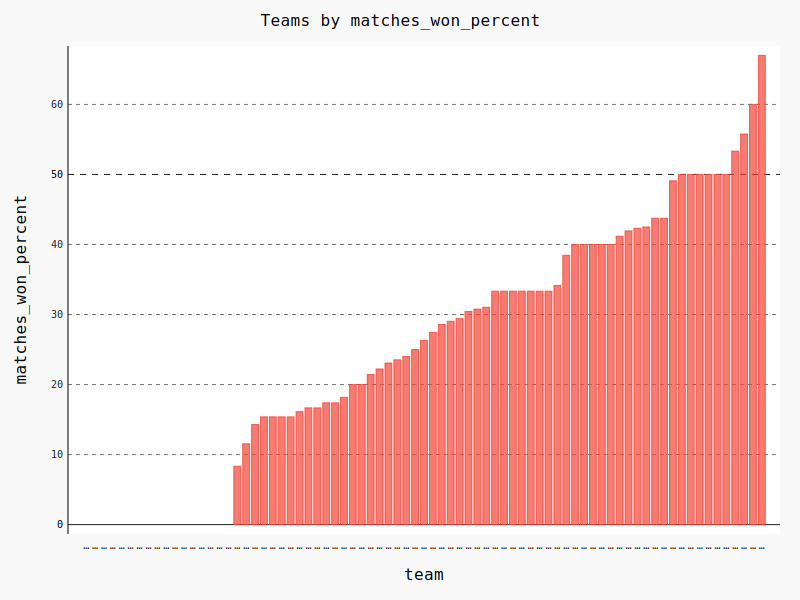

In [6]:
show(graph_teams_stat_bars(team_stats, 'matches_won_percent'))

Pudium score is an invented measure on how good the teams are by looking at the 4 first teams from each cup. The first team receives 8 points, the second 4, the third 2, and the fourth 1. All the rest receive 0 points. As you can see, the scoring is exponential, because each position implies an exponentially bigger amount of matches won than the next one.

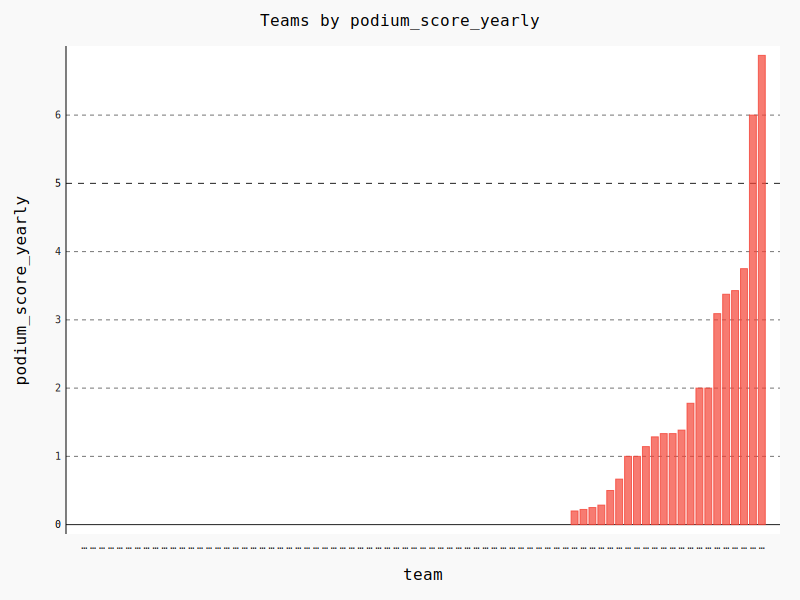

In [7]:
show(graph_teams_stat_bars(team_stats, 'podium_score_yearly'))

Matches
-------

Now we need to get the matches data, including the "reversed" duplication of matches, and adding the team stats in each match.

In [8]:
matches = get_matches(with_team_stats=True,
                      duplicate_with_reversed=duplicate_with_reversed,
                      exclude_ties=exclude_ties)
        
matches

,id,score1,score2,team1,team2,year,score_diff,winner,matches_played,matches_won,...,podium_score_yearly,cups_won_yearly,matches_played_2,matches_won_2,years_played_2,podium_score_2,cups_won_2,matches_won_percent_2,podium_score_yearly_2,cups_won_yearly_2
53,53,4,0,Brazil,Mexico,1950,4,1,100.0,67.0,...,6,0.294118,51.0,14.0,14.0,False,0.0,27.450980,0,0.000000
54,54,2,0,England,Chile,1950,2,1,62.0,26.0,...,1.28571,0.071429,31.0,9.0,8.0,4,0.0,29.032258,0.5,0.000000
55,55,3,1,Spain,USA,1950,2,1,56.0,28.0,...,1.38462,0.076923,30.0,6.0,8.0,False,0.0,20.000000,0,0.000000
56,56,3,2,Sweden,Italy,1950,1,1,41.0,14.0,...,1.77778,0.000000,74.0,37.0,16.0,54,2.0,50.000000,3.375,0.125000
57,57,3,0,Yugoslavia,Switzerland,1950,3,1,34.0,14.0,...,0.25,0.000000,29.0,9.0,8.0,False,0.0,31.034483,0,0.000000
59,59,4,1,Yugoslavia,Mexico,1950,3,1,34.0,14.0,...,0.25,0.000000,51.0,14.0,14.0,False,0.0,27.450980,0,0.000000
60,60,2,0,Spain,Chile,1950,2,1,56.0,28.0,...,1.38462,0.076923,31.0,9.0,8.0,4,0.0,29.032258,0.5,0.000000
62,62,1,0,USA,England,1950,1,1,30.0,6.0,...,0,0.000000,62.0,26.0,14.0,18,1.0,41.935484,1.28571,0.071429
63,63,2,0,Brazil,Yugoslavia,1950,2,1,100.0,67.0,...,6,0.294118,34.0,14.0,8.0,2,0.0,41.176471,0.25,0.000000
64,64,1,0,Spain,England,1950,1,1,56.0,28.0,...,1.38462,0.076923,62.0,26.0,14.0,18,1.0,41.935484,1.28571,0.071429


Are the results able to be classified? Can we see a pattern, some kind of grouping of results based on the stats of bot teams?

Let's try visualizing two of the most interesting ones: matches won percent, and podium score yearly (mean).

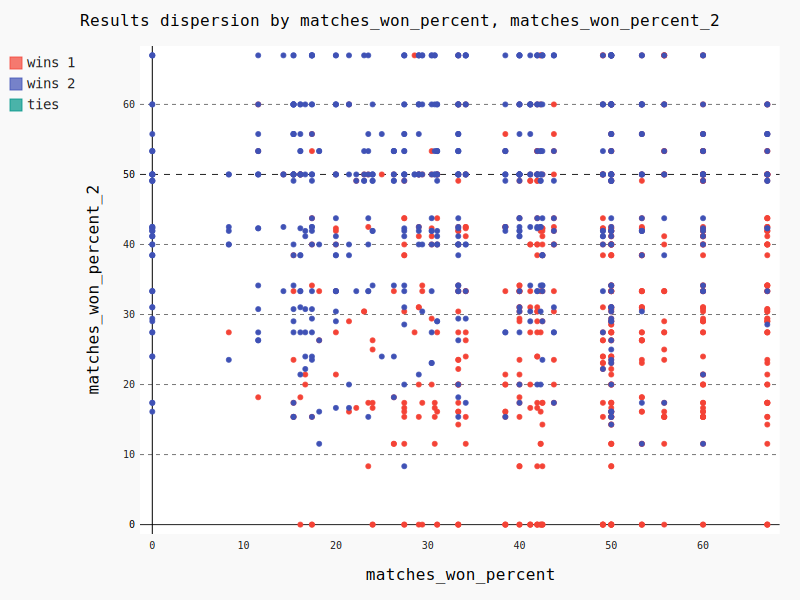

In [9]:
show(graph_matches_results_scatter(matches, 'matches_won_percent', 'matches_won_percent_2'))

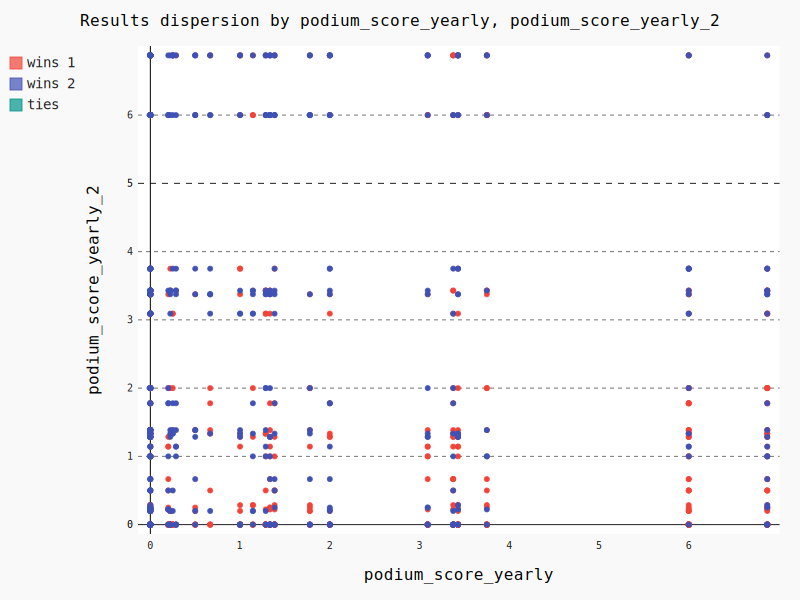

In [10]:
show(graph_matches_results_scatter(matches, 'podium_score_yearly', 'podium_score_yearly_2'))

Before any conclussions: there is more there than what you can see with your eyes. At some location, there could be more than 1 point, and you only see the one on the top.

The first graph tells us something that most people already expect: there is a small tendency on the result, the team with the better matches won percent tends to win. The second graph also shows a similar relation between podium score yearly and the result, even if it's not visible to the eye because of the overlapping of dots.

But remember, the classifier can learn a lot more than just those simple relations based on the info we give to it. These graphs were just a screening to confirm some basic intuitions.

Learn
-----

Ok, now we have everything we need. Lets feed the selected input features to a the neural network classifier, and let it learn.

We have to normalize the data, otherwise the features with smaller values will impose a greater weight on the prediction.

Also, we use a percentage of the inputs to train, but keep the rest "hidden", we don't let the classifier see them while learning. After the training we use those inputs to "test" the ability of the classifier to predict data it has never seen before (and data we already know the correct answer).

In [11]:
inputs, outputs = extract_samples(matches,
                                  input_features,
                                  output_feature)

normalizer, inputs = normalize(inputs)

train_inputs, train_outputs, test_inputs, test_outputs = split_samples(inputs, outputs)

n = buildNetwork(len(input_features),
                 10 * len(input_features),
                 10 * len(input_features),
                 1,
                 outclass=SigmoidLayer,
                 bias=True)


To be able to evaluate the results and show progress on the learning cycle, we need these two functions wich help us calculate how well the network can predict the results from the matches used to learn, and the matches it doesn't know.

In [12]:
def neural_result(input):
    """Call the neural network, and translates its output to a match result."""
    n_output = n.activate(input) 
    if n_output >= 0.5:
        return 2
    else:
        return 1
    
def test_network():
    """Calculate train and test sets errors."""
    print (100 - percentError(map(neural_result, train_inputs), train_outputs), 
           100 - percentError(map(neural_result, test_inputs), test_outputs))

Create a train set (a kind of dataset that pybrain uses to train neural networks), and display initial accuracy on both sets (train and test).

In [13]:
train_set = ClassificationDataSet(len(input_features))

for i, input_line in enumerate(train_inputs):
    train_set.addSample(train_inputs[i], [train_outputs[i] - 1])

trainer = BackpropTrainer(n, dataset=train_set, momentum=0.5, weightdecay=0.0)

train_set.assignClasses()

test_network()

(49.72617743702081, 50.798722044728436)


Train the network, for a given number of iterations. You can re-run this step many times, and it will keep learning, but as you know, if you train too much you can end overfitting the training data (this is visible when the test set accuracy starts to decrease).

In [16]:
for i in range(20):
    trainer.train()
    test_network()

(76.4512595837897, 69.6485623003195)
(75.90361445783132, 69.32907348242811)
(75.02738225629793, 68.69009584664536)
(75.24644030668128, 70.92651757188499)
(74.37020810514787, 69.96805111821087)
(75.90361445783132, 69.6485623003195)
(76.56078860898138, 69.96805111821087)
(74.58926615553122, 71.24600638977635)
(75.5750273822563, 69.00958466453675)
(75.46549835706462, 69.32907348242811)
(74.91785323110625, 69.96805111821087)
(74.37020810514787, 71.24600638977635)
(76.013143483023, 69.32907348242811)
(75.5750273822563, 67.73162939297124)
(74.26067907995619, 70.6070287539936)
(76.34173055859803, 69.32907348242811)
(76.56078860898138, 68.69009584664536)
(74.37020810514787, 68.370607028754)
(74.58926615553122, 70.92651757188499)
(75.5750273822563, 67.73162939297124)


The closer this score is to 100%, the better the classifier is doing its predictions. A score of 100 means the classifier allways predicts the exact real result, something impossible.

And something around 75% sounds impressive, but in fact is not **that** good. It's pretty good, but consider that just throwing a coin will get you 50%. So this sits in the middle between throwing a coin and having a time machine.

Predict
-------

With the classifier already trained, we can start making predictions. But we need a little function able to translate inputs like this: (2014, 'Argentina', 'Brazil'), to the numeric inputs the classifier expects (based on the input features).

This function does the conversion, also normalizes the data with the same normalizer used before, and then just asks the classifier for the prediction.

In [17]:
def predict(year, team1, team2, reverse=True):
    inputs = []
    
    if reverse:
        assert predict(year, team2, team1, False)
    
    for feature in input_features:
        from_team_2 = '_2' in feature
        feature = feature.replace('_2', '')
        
        if feature in team_stats.columns.values:
            team = team2 if from_team_2 else team1
            value = team_stats.loc[team, feature]
        elif feature == 'year':
            value = year
        else:
            raise ValueError("Don't know where to get feature: " + feature)
            
        inputs.append(value)
    print inputs, normalizer    
    inputs = normalizer.transform([inputs])[0]
    result = neural_result(inputs)
    
    if result == 0:
        return 'tie'
    elif result == 1:
        return team1
    elif result == 2:
        return team2
    else:
        return 'Unknown result: ' + str(result)

In [18]:
normalizer.transform([[0,0,0,0,0]])[0]

array([-103.81386861,   -2.31081138,   -0.80878249,   -2.31081138,
         -0.80878249])

Some predictions about the past, compared to real results:
----------------------------------------------------------

Even while we know those results and some of them where used to train, that doesn't guarantee the real result is what the classifier will predict.

In [19]:
predict(1950, 'Mexico', 'Brazil')  # real result: 4-0 wins Brazil

[1950, 67.0, 6.0, 27.450980392156865, 0.0] StandardScaler(copy=True, with_mean=True, with_std=True)
[1950, 27.450980392156865, 0.0, 67.0, 6.0] StandardScaler(copy=True, with_mean=True, with_std=True)


'Brazil'

In [20]:
predict(1990, 'United Arab Emirates', 'Colombia')  # real result: 2-0 wins Colombia


[1990, 40.0, 0.0, 0.0, 0.0] StandardScaler(copy=True, with_mean=True, with_std=True)
[1990, 0.0, 0.0, 40.0, 0.0] StandardScaler(copy=True, with_mean=True, with_std=True)


'Colombia'

In [21]:
predict(2002, 'South Africa', 'Spain')  # real result: 2-3 wins Spain

[2002, 50.0, 1.3846153846153846, 22.22222222222222, 0.0] StandardScaler(copy=True, with_mean=True, with_std=True)
[2002, 22.22222222222222, 0.0, 50.0, 1.3846153846153846] StandardScaler(copy=True, with_mean=True, with_std=True)


'Spain'

In [22]:
predict(2010, 'Japan', 'Cameroon')  # real result: 1-0 wins Japan

[2010, 17.391304347826086, 0.0, 23.52941176470588, 0.0] StandardScaler(copy=True, with_mean=True, with_std=True)
[2010, 23.52941176470588, 0.0, 17.391304347826086, 0.0] StandardScaler(copy=True, with_mean=True, with_std=True)


'Japan'

Some predictions about the future:
----------------------------------

(at least these where "future" at the moment of programming)

In [23]:
predict(2014, 'Argentina', 'Brazil')

[2014, 67.0, 6.0, 53.333333333333336, 3.4285714285714284] StandardScaler(copy=True, with_mean=True, with_std=True)
[2014, 53.333333333333336, 3.4285714285714284, 67.0, 6.0] StandardScaler(copy=True, with_mean=True, with_std=True)


'Argentina'

In [24]:
predict(2014, 'Spain', 'Haiti')

[2014, 0.0, 0.0, 50.0, 1.3846153846153846] StandardScaler(copy=True, with_mean=True, with_std=True)
[2014, 50.0, 1.3846153846153846, 0.0, 0.0] StandardScaler(copy=True, with_mean=True, with_std=True)


'Spain'

In [25]:
predict(2014, 'Russia', 'Germany')

[2014, 60.0, 6.875, 42.5, 0.2] StandardScaler(copy=True, with_mean=True, with_std=True)
[2014, 42.5, 0.2, 60.0, 6.875] StandardScaler(copy=True, with_mean=True, with_std=True)


'Germany'

In [26]:
predict(2014, 'Russia', 'Russia')

[2014, 42.5, 0.2, 42.5, 0.2] StandardScaler(copy=True, with_mean=True, with_std=True)
[2014, 42.5, 0.2, 42.5, 0.2] StandardScaler(copy=True, with_mean=True, with_std=True)


'Russia'

In [27]:
predict(2018, 'Portugal', 'Spain')

[2018, 50.0, 1.3846153846153846, 50.0, 1.0] StandardScaler(copy=True, with_mean=True, with_std=True)
[2018, 50.0, 1.0, 50.0, 1.3846153846153846] StandardScaler(copy=True, with_mean=True, with_std=True)


'Spain'

In [33]:
predict(2018, 'Portugal', 'Morocco')

[2018, 15.384615384615385, 0.0, 50.0, 1.0] StandardScaler(copy=True, with_mean=True, with_std=True)
[2018, 50.0, 1.0, 15.384615384615385, 0.0] StandardScaler(copy=True, with_mean=True, with_std=True)


'Portugal'